# Atividade  
Ajustar o script para classificar gêneros musicais do Spotify considerando a base de dados [disponível no HuggingFace](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from math import sqrt
plt.rcParams['figure.figsize'] = [16, 10]

pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 200

import random
from random import seed
from random import randrange
import requests
import io
    
# Downloading the csv file from your GitHub account

url = "https://raw.githubusercontent.com/Zuluke/Projetos-AM/main/spotify_activity/dataset.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

## Sem atributos categóricos

### Preprocessamento  
Antes de tudo, é fundamental remover os atributos categóricos não-numéricos. No caso do atributo "key", ele será mantido sendo tratado com método one-hot encoding, tendo a coluna referente ao valor desconhecido descartada. Por último, os atributos popularity, duration_ms, loudness, tempo e time_signature serão padronizados com min_max_scaler para manter os valores entre 0 e 1.

In [9]:
scaler = MinMaxScaler()

# Fazendo uma cópia de amostra do conjunto de dados
df_aj, _, = train_test_split(df, train_size=0.5, stratify=df.track_genre)

# Removendo colunas categóricas nominais e de palavras de baixo calão
df_aj = df_aj.drop(columns=['Unnamed: 0','track_id','energy','speechiness','acousticness','instrumentalness','liveness',
                                      'duration_ms','explicit' ,'artists', 'popularity','loudness','time_signature',
                                      'album_name', 'tempo','track_name','key', 'mode','danceability'])
df_aj = df_aj

df_aj.dropna(inplace=True, axis=0, how='any')

# Criando dicionários para converter labels em números e vice-versa
dict_label_num = {}
dict_num_label = {}
for index in range(len(df_aj.track_genre.unique())):
  dict_label_num[df_aj.track_genre.unique()[index]] = index
  dict_num_label[index] = df_aj.track_genre.unique()[index]

# Renomeando valores de track_genre
df_aj.track_genre = df_aj.track_genre.map(dict_label_num)

In [10]:
df_aj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57000 entries, 64742 to 37697
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   valence      57000 non-null  float64
 1   track_genre  57000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


In [11]:
# Divisão de dados de atributos e classe
sptf_X = df_aj.drop(columns='track_genre') #caracteristicas
sptf_Y = df_aj.track_genre #classe

# Divisão em conjuntos de treino, teste e validação
sptf_X_train, sptf_X_test, sptf_Y_train, sptf_Y_test = train_test_split(sptf_X, sptf_Y, test_size=0.40, random_state=10)
sptf_X_test, sptf_X_valid, sptf_Y_test, sptf_Y_valid = train_test_split(sptf_X_test, sptf_Y_test, test_size=0.50, random_state=10)

sptf_X_train = sptf_X_train.values
sptf_X_test = sptf_X_test.values
sptf_X_valid = sptf_X_valid.values
sptf_Y_train = sptf_Y_train.values
sptf_Y_test = sptf_Y_test.values
sptf_Y_valid = sptf_Y_valid.values

### KNN

Distância manhattan: 100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


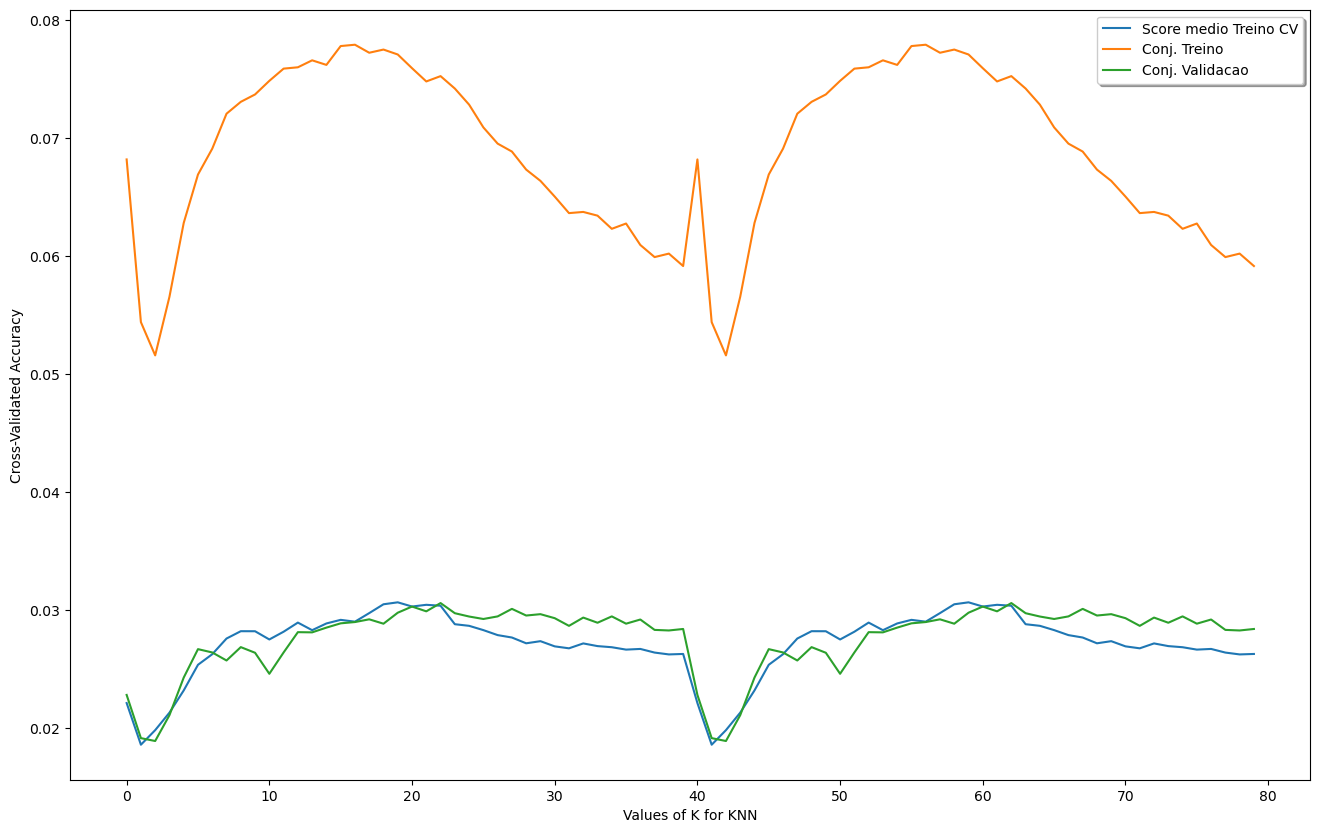

F1 de treinamento clf: 0.077
F1 de validação clf: 0.030
F1 de teste clf: 0.030


In [13]:
# we create an instance of Neighbours Classifier and fit the data.
sptf_clf = neighbors.KNeighborsClassifier()

# Construindo o espaco de busca por configuracoes do classificador
k_range = range(1, 81, 2) #k
k_scores_train = []
k_scores_train_full = []
k_scores_valid = []
vet_distancias = ['euclidean', 'manhattan']
best_f1 = 0
#p_range = range(1, 198) #k
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in vet_distancias:
  for j in tqdm(k_range, desc=f'Distância {k}'):
    knn = neighbors.KNeighborsClassifier(n_neighbors=j, metric=k)
    scores = cross_val_score(knn, sptf_X_train, sptf_Y_train, cv=5, scoring='f1_weighted')
    k_scores_train.append(scores.mean())
    if scores.mean() > best_f1:
      sptf_clf = neighbors.KNeighborsClassifier(n_neighbors=j, metric=k)
      best_f1 = scores.mean()
    knn.fit(sptf_X_train, sptf_Y_train)
    k_scores_train_full.append(f1_score(sptf_Y_train, knn.predict(sptf_X_train), average='weighted'))
    k_scores_valid.append(f1_score(sptf_Y_valid, knn.predict(sptf_X_valid), average='weighted'))

#treinando o classificador
sptf_clf = sptf_clf.fit(sptf_X_train, sptf_Y_train)

# plot to see clearly
plt.plot(list(range(0,len(k_scores_train))), k_scores_train)
plt.plot(list(range(0,len(k_scores_train_full))), k_scores_train_full)
plt.plot(list(range(0,len(k_scores_valid))), k_scores_valid)
plt.legend(('Score medio Treino CV', 'Conj. Treino', 'Conj. Validacao'),
           loc='upper right', shadow=True)
plt.xlabel('Values of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print("F1 de treinamento clf: %0.3f" %  f1_score(sptf_Y_train, sptf_clf.predict(sptf_X_train), average='weighted'))
print("F1 de validação clf: %0.3f" %  f1_score(sptf_Y_valid, sptf_clf.predict(sptf_X_valid), average='weighted'))
print("F1 de teste clf: %0.3f" %  f1_score(sptf_Y_test, sptf_clf.predict(sptf_X_test), average='weighted'))

In [18]:
sptf_clf

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

### LVQ

In [19]:
# LVQ for the Ionosphere Dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
	distances = list()
	for codebook in codebooks:
		dist = euclidean_distance(codebook, test_row)
		distances.append((codebook, dist))
	distances.sort(key=lambda tup: tup[1])
	return distances[0][0]

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]

# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook

# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
	codebooks = [random_codebook(train) for i in range(n_codebooks)]
	for epoch in range(epochs):
		rate = lrate * (1.0-(epoch/float(epochs)))
		for row in train:
			bmu = get_best_matching_unit(codebooks, row)
			for i in range(len(row)-1):
				error = row[i] - bmu[i]
				if bmu[-1] == row[-1]:
					bmu[i] += rate * error
				else:
					bmu[i] -= rate * error
	return codebooks

# LVQ Algorithm
def learning_vector_quantization(train, test, n_codebooks, lrate, epochs):
	codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
	predictions = list()
	for row in test:
		output = predict(codebooks, row)
		predictions.append(output)
	return(predictions)


In [20]:
import numpy as np

# Adjusting evaluation algorithm with cross validation split to consider F1-score
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in range(len(folds)):
		train_set = [folds[index] for index in range(len(folds)) if (not (index != fold))]
		train_set = sum(train_set, [])
		test_set = list()
		for row in folds[fold]:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in folds[fold]]
		f1score = f1_score(actual, predicted, average='weighted')
		scores.append(f1score)
	return scores

# Test LVQ on Spotify dataset
random.seed(1)
# load and prepare data
dataset = df_aj.copy().values
# evaluate algorithm
n_folds = 5
n_epochs = 20
learn_rate = [0.01,0.2, 0.5]
n_codebooks = [40,50,60]
best_mean_f1 = [0]
best_scores = [0] * n_folds

for rate in learn_rate:
	for prototypes in tqdm(n_codebooks, desc=f'Taxa {rate}'):
		scores = evaluate_algorithm(dataset, learning_vector_quantization, n_folds, prototypes, rate, n_epochs)
		if (sum(scores)/float(len(scores))) > best_mean_f1:
			best_mean_f1 = (sum(scores)/float(len(scores)))
			best_scores = scores
	
	print(f'Rate: {rate}')
	print('Melhores pontuações: %s' % best_scores)
	print('Melhor F1-score médio: %.3f%%' % best_mean_f1,'\n\n')

print('Melhores pontuações: %s' % best_scores)
print('Melhor F1-score médio: %.6f%%' % best_mean_f1)

Taxa 0.01: 100%|██████████| 3/3 [08:23<00:00, 167.73s/it]


Rate: 0.01
Melhores pontuações: [0.000129212694109098, 0.00014653959651258951, 0.00021208604076609303, 0.00014357673779124687, 0.00013486823025896043]
Melhor F1-score médio: 0.000% 




Taxa 0.2:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\pichau\AppData\Local\Temp\ipykernel_16572\3645881548.py:78: RuntimeWarning: overflow encountered in scalar power
  distance += (row1[i] - row2[i])**2
C:\Users\pichau\AppData\Local\Temp\ipykernel_16572\3645881548.py:114: RuntimeWarning: overflow encountered in scalar subtract
  bmu[i] -= rate * error
C:\Users\pichau\AppData\Local\Temp\ipykernel_16572\3645881548.py:112: RuntimeWarning: invalid value encountered in scalar add
  bmu[i] += rate * error
C:\Users\pichau\AppData\Local\Temp\ipykernel_16572\3645881548.py:78: RuntimeWarning: overflow encountered in scalar power
  distance += (row1[i] - row2[i])**2
C:\Users\pichau\AppData\Local\Temp\ipykernel_16572\3645881548.py:114: RuntimeWarning: overflow encountered in scalar subtract
  bmu[i] -= rate * error
C:\Users\pichau\AppData\Local\Temp\ipykernel_16572\3645881548.py:112: RuntimeWarning: invalid value encountered in scalar add
  bmu[i] += rate * error
C:\Users\pichau\AppData\Local\T

KeyboardInterrupt: 